In [1]:
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy     as np
import xarray    as xr
import time      as clock
import warnings
xr.set_options(keep_attrs=True)
do_parallel   = False
parallel_nprc = 48   # number of dask workers
parallel_tmem = 200  # max. available RAM

/albedo/home/pscholz/tripyview


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [2]:
if do_parallel:
    from dask.distributed import Client
    # from dask.diagnostics import ProgressBar
    import dask
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client

 --> memory_limit: 4.167 GB


In [3]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/dart_test/'
save_path = None 
save_fname= None

#_____________________________________________________________________________________
which_cycl= None #5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'hovm'

input_paths= list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'temp'
# year      = [1958, 2019]
year      = [1958, 1961]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/' # None #
ref_name  = None #'TKE, ck=0.1' # None
ref_year  = None #[1958, 2019]
ref_mon, ref_day, ref_record = None, None, None
ref_cstr, ref_cnum = 'wbgyr', 20
ref_cref, ref_crange, ref_cmin, ref_cmax, ref_cfac, ref_climit = None, None, None, None, None, None
ref_chist, ref_ctresh = True, 0.995
ref_rescale = None

#_____________________________________________________________________________________
box_region = list()
box_region.append('global')
# box_region.append('ocean_basins/Arctic_Basin.shp')
# box_region.append('ocean_basins/Eurasian_Basin.shp')
# box_region.append('mpas_region/Canada_Basin.shp')
# box_region.append('mpas_region/North_Atlantic_Ocean.shp')
# box_region.append('mpas_region/Greenland_Sea.shp')
# box_region.append('mpas_region/Irminger_Sea.shp')
# box_region.append('mpas_region/Norwegian_Sea.shp')
# box_region.append('mpas_region/Labrador_Sea.shp')
# box_region.append('mpas_region/North_Pacific_Ocean.shp')
# box_region.append('mpas_region/South_Pacific_Ocean.shp')
# box_region.append('mpas_region/Southern_Ocean.shp')
# box_region.append('mpas_region/Western_Weddell_Sea.shp')

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = None
crange, cmin, cmax, cfac, climit = None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncol      = 2        # number of pannel columns in figure
which_dpi = 300
do_rescale= None
do_reffig = True
figfac    = [8, 3.5] #ä[7, 3.5]

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (which_cycl is not None) and (which_cycl != "None"): 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])
    
    if (ref_path is not None) and (ref_path != "None"): 
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)
        
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path is not None) and (ref_path != "None"): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
else:
    do_reffig=False
    
#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path != None and ref_path != 'None'): 
    if isinstance(ref_path, list): 
        input_paths, input_names = input_paths + ref_path, input_names + ref_name 
    else:    
        input_paths, input_names = input_paths + list([ref_path]), input_names + list([ref_name])

#______________________________________________________________________________________________________
# define index regions --> reading shape files
box = list()
shp_path = os.path.join(tpv.__path__[0],'shapefiles/')
for region in box_region:
    if region == 'global' or isinstance(region,list): 
        print('global')
        box.append(region)
    else: 
        print(tpv.__path__[0],region)
        box.append(shp.Reader(os.path.join(shp_path,region)))    

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/dart_test
 > load  *.pckl file: tripyview_fesom2_dart_test_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/dart_test
 > id              = dart_test
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 3160340
 > #elem           = 6262485
 > #lvls           = 70
___________________________________________
global


In [5]:
list_hovm  = list()
#___LOAD FESOM2 DATA___________________________________________________________________________________
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________
    yeari, moni = year, mon
    if (ii==0) and (ref_path != None and ref_path != 'None'): yeari, moni = ref_year, ref_mon
        
    #__________________________________________________________________________________________________
    # load fesom2 data
    if not vname=='Kv*N2':
        data  = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=yeari, mon=moni,  descript=descript, 
                                    do_tarithm='None', do_zarithm='None', do_info=False, do_load=False, do_persist=True )
        
    else:
        data  = tpv.load_data_fesom2(mesh, datapath, vname='Kv', year=yeari, mon=moni, descript=descript, 
                                     do_tarithm='None', do_zarithm='None', do_info=False, do_load=False, do_persist=True)
        data2 = tpv.load_data_fesom2(mesh, datapath, vname='N2', year=yeari, mon=moni, descript=descript, 
                                     do_tarithm='None', do_zarithm='None', do_info=False, do_load=False, do_persist=True)
        data['Kv'].data = data['Kv'].data * data2['N2'].data
        data  = data.rename(dict({'Kv':'Kv*N2'}))
        data['Kv*N2'].attrs['units'], data['Kv*N2'].attrs['description'], data['Kv*N2'].attrs['long_name'] = 'm^2/s^3', 'Kv * N^2', 'Kv * N^2'
        del(data2)
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))

    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    
    #_________________________________________________________________________________________________
    # create hovmoeller from reference data, if given 
    ts = clock.time()
    if (ii==0) and (ref_path != None and ref_path != 'None'):
        data_hovmref = tpv.load_index_fesom2(mesh, data, box, do_harithm='wmean')
        print(' --> elasped time to comp. ref. hovm.: {:3.2f} min.'.format( (clock.time()-ts)/60  ))   
        for ii, data_ii in enumerate(data_hovm):
            print(' --> data_hovm[{:d}] uses {:3.2f} Mb:'.format(ii, data_hovm[ii].nbytes/(1024**2)))
        del(data)
        continue

    # create hovmoeller from data
    data_hovm = tpv.load_index_fesom2(mesh, data, box, do_harithm='wmean')
    print(' --> elasped time to comp. data hovm.: {:3.2f} min.'.format( (clock.time()-ts)/60  ))   
    for ii, data_ii in enumerate(data_hovm):
        print(' --> data_hovm[{:s}] uses {:3.2f} Mb:'.format(data_hovm[ii][list(data_hovm[ii].keys())[0]].attrs['boxname'], data_hovm[ii].nbytes/(1024**2)))
    del(data)
    
    #_________________________________________________________________________________________________
    # compute hovmoeller anomaly if reference run is given
    if (ref_path != None and ref_path != 'None'):
        list_hovm.append(tpv.do_indexanomaly(data_hovm, data_hovmref))
        
    # compute abosulte hovmoeller diagramm    
    else: 
        list_hovm.append(data_hovm)
    del(data_hovm)
    
if (ref_path != None and ref_path != 'None'): del(data_hovmref)    

0 /albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/ TKE
 --> elasped time to load data: 0.04 min.
 --> data uses 39.84 Gb:
 --> elasped time to comp. index: 0.13 min.
 --> data_hovm[global] uses 0.01 Mb:


--> histo: cmin, cmax =  0.8793878555297852 18.16649627685547
{'cstr': 'blue2red', 'cnum': 20, 'chist': True, 'ctresh': 0.995, 'cmin': 0.88, 'cmax': 18.17, 'cref': 10.0, 'cmap': <matplotlib.colors.ListedColormap object at 0x1552a5e95b80>, 'clevel': array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ,
       11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5,
       17. , 17.5, 18. , 18.5])}


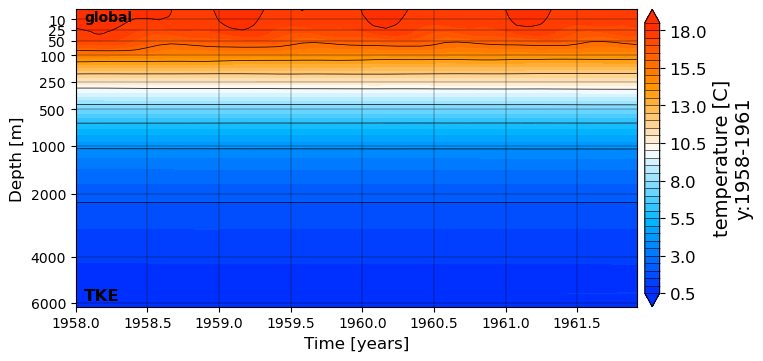

In [6]:
#___PLOT HOVM__________________________________________________________________________________________
spath  = save_path
sname  = vname
ncol   = np.min([ncol,len(list_hovm)])    
nrow   = np.ceil(len(list_hovm)/ncol).astype('int')
for ii in range(len(box)):
    slabel = list_hovm[0][ii][sname].attrs['str_lsave']
    sbox   = list_hovm[0][ii][vname].attrs['boxname'].replace(' ','_').lower()
    if spath is not None: spath  = '{}/{}_{}_{}_{}.png'.format(spath, which_mode, sname, sbox, slabel) 
    if save_fname is not None: spath = save_fname
    cinfo2 = cinfo.copy()    
    fig, ax, cbar = tpv.plot_index_hovm(list_hovm, boxidx=ii, cinfo=cinfo2, figsize=[ncol*figfac[0], nrow*figfac[1]], n_rc=[nrow, ncol], 
                                        do_rescale=do_rescale, do_reffig=do_reffig, ref_cinfo=ref_cinfo, ref_rescale=ref_rescale, 
                                        pos_gap=[0.01, 0.01], pos_extend=[0.05, 0.05, 0.85,0.90], 
                                        do_save = spath, save_dpi=which_dpi )